## 1. Import Libraries

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pickle
import json
import os
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## 2. Load Saved Models

In [42]:
# Check if models directory exists
if not os.path.exists('models'):
    raise FileNotFoundError("❌ 'models' directory not found! Run model_training.ipynb first.")

print("📁 Loading saved models...")
print("="*50)

# Load best model
best_model = joblib.load('models/best_model.joblib')
print("✅ Best model loaded")

# Load individual models
dt_model = joblib.load('models/decision_tree_model.joblib')
print("✅ Decision Tree loaded")

rf_model = joblib.load('models/random_forest_model.joblib')
print("✅ Random Forest loaded")

# Try loading XGBoost
try:
    xgb_model = joblib.load('models/xgboost_model.joblib')
    XGBOOST_AVAILABLE = True
    print("✅ XGBoost loaded")
except:
    XGBOOST_AVAILABLE = False
    print("⚠️ XGBoost model not found")

# Load scaler and encoder
scaler = joblib.load('models/scaler.joblib')
print("✅ Scaler loaded")

label_encoder = joblib.load('models/label_encoder.joblib')
print("✅ Label encoder loaded")

# Load feature columns
with open('models/feature_columns.txt', 'r') as f:
    feature_cols = f.read().strip().split('\n')
print(f"✅ Feature columns loaded: {feature_cols}")

# Load model info
with open('models/model_info.json', 'r') as f:
    model_info = json.load(f)
print("✅ Model info loaded")

print(f"\n📊 Model Info:")
print(f"   Best Model: {model_info['best_model_name']}")
print(f"   Test Accuracy: {model_info['test_accuracy']:.4f}")
print(f"   F1-Score: {model_info['f1_score']:.4f}")
print(f"   Classes: {model_info['class_names']}")

📁 Loading saved models...
✅ Best model loaded
✅ Decision Tree loaded
✅ Random Forest loaded
✅ XGBoost loaded
✅ Scaler loaded
✅ Label encoder loaded
✅ Feature columns loaded: ['pm25', 'pm10', 'no2', 'co', 'so2', 'o3', 'temperature', 'humidity', 'wind_speed']
✅ Model info loaded

📊 Model Info:
   Best Model: XGBoost
   Test Accuracy: 0.9915
   F1-Score: 0.9915
   Classes: ['Agricultural', 'Burning', 'Industrial', 'Natural', 'Vehicular']


## 3. Load Test Dataset

In [43]:
# Load the FINAL dataset for testing (different from training set)
df = pd.read_csv('data/final/enviroscan_final_dataset.csv')
print(f"✅ Final dataset loaded: {len(df):,} records")
print(f"   Columns: {len(df.columns)}")

# Get class names
class_names = label_encoder.classes_
print(f"   Classes: {list(class_names)}")

# Check if pollution_source column exists
if 'pollution_source' in df.columns:
    print(f"\n📊 Pollution Source Distribution:")
    for source, count in df['pollution_source'].value_counts().items():
        print(f"   {source}: {count:,}")
else:
    print("⚠️ 'pollution_source' column not found - will only do predictions")

# Display sample
df.head()

✅ Final dataset loaded: 106,369 records
   Columns: 33
   Classes: ['Agricultural', 'Burning', 'Industrial', 'Natural', 'Vehicular']

📊 Pollution Source Distribution:
   Vehicular: 42,445
   Industrial: 23,372
   Agricultural: 21,389
   Natural: 12,061
   Burning: 7,102


,state,district,location_id,location_name,latitude,longitude,datetime_ist,hour,day_of_week,month,...,roads_count,industrial_distance_m,industrial_area_sqm,agricultural_distance_m,agricultural_area_sqm,dump_sites_distance_m,dump_sites_count,pollution_source,source_encoded,confidence
0,Andhra Pradesh,Tirupati,5649,"Tirumala, Tirupati - APPCB",13.67,79.35,2025-11-08 15:15:00+05:30,15,5,11,...,67,396.9,7470.18,9999.0,0.0,976.01,3,Natural,4,Low
1,Andhra Pradesh,Tirupati,5649,"Tirumala, Tirupati - APPCB",13.67,79.35,2025-11-08 15:30:00+05:30,15,5,11,...,67,396.9,7470.18,9999.0,0.0,976.01,3,Burning,3,Low
2,Andhra Pradesh,Tirupati,5649,"Tirumala, Tirupati - APPCB",13.67,79.35,2025-11-08 15:45:00+05:30,15,5,11,...,67,396.9,7470.18,9999.0,0.0,976.01,3,Burning,3,Low
3,Andhra Pradesh,Tirupati,5649,"Tirumala, Tirupati - APPCB",13.67,79.35,2025-11-08 16:00:00+05:30,16,5,11,...,67,396.9,7470.18,9999.0,0.0,976.01,3,Burning,3,Low
4,Andhra Pradesh,Tirupati,5649,"Tirumala, Tirupati - APPCB",13.67,79.35,2025-11-08 16:15:00+05:30,16,5,11,...,67,396.9,7470.18,9999.0,0.0,976.01,3,Burning,3,Low


## 4. Prepare Test Data

In [44]:
# Prepare test data from final dataset
from sklearn.model_selection import train_test_split

# Check which features are available
available_features = [f for f in feature_cols if f in df.columns]
missing_features = [f for f in feature_cols if f not in df.columns]

print(f"📊 Feature Check:")
print(f"   Required: {len(feature_cols)}")
print(f"   Available: {len(available_features)}")
if missing_features:
    print(f"   ⚠️ Missing: {missing_features}")

# Prepare features - fill missing columns with 0
X_df = df[available_features].copy()
for f in missing_features:
    X_df[f] = 0
X_df = X_df[feature_cols]  # Reorder to match training

X_full = X_df.fillna(0).values

# Check if we have labels
HAS_LABELS = 'pollution_source' in df.columns

if HAS_LABELS:
    # Filter to only known classes
    known_classes = set(label_encoder.classes_)
    df_labeled = df[df['pollution_source'].isin(known_classes)].copy()
    
    X_labeled = df_labeled[available_features].copy()
    for f in missing_features:
        X_labeled[f] = 0
    X_labeled = X_labeled[feature_cols].fillna(0).values
    
    y_full = label_encoder.transform(df_labeled['pollution_source'])
    
    # Split for proper testing
    X_train, X_test, y_train, y_test = train_test_split(
        X_labeled, y_full,
        test_size=0.20,
        random_state=42,
        stratify=y_full
    )
    
    X_test_scaled = scaler.transform(X_test)
    
    print(f"\n✅ Test data prepared with labels:")
    print(f"   Total labeled: {len(X_labeled):,}")
    print(f"   Training set: {len(X_train):,}")
    print(f"   Test set: {len(X_test):,}")
else:
    # No labels - just prepare for prediction
    X_test = X_full
    X_test_scaled = scaler.transform(X_test)
    print(f"\n✅ Test data prepared (NO labels - prediction only):")
    print(f"   Total samples: {len(X_test):,}")

📊 Feature Check:
   Required: 9
   Available: 9

✅ Test data prepared with labels:
   Total labeled: 106,369
   Training set: 85,095
   Test set: 21,274


## 5. Test Best Model on Full Dataset

In [45]:
print(f"🧪 Testing Best Model ({model_info['best_model_name']}) on Final Dataset...")
print("="*50)

if HAS_LABELS:
    # Make predictions on TEST SET
    y_pred = best_model.predict(X_test_scaled)
    y_true = y_test

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"\n📊 Performance Metrics (on UNSEEN test data):")
    print(f"   Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall:    {recall:.4f}")
    print(f"   F1-Score:  {f1:.4f}")

    # Check for overfitting
    train_pred = best_model.predict(scaler.transform(X_train))
    train_accuracy = accuracy_score(y_train, train_pred)
    overfit_gap = train_accuracy - accuracy

    print(f"\n📊 Overfitting Check:")
    print(f"   Train Accuracy: {train_accuracy:.4f}")
    print(f"   Test Accuracy:  {accuracy:.4f}")
    print(f"   Overfit Gap:    {overfit_gap:.4f}")

    if overfit_gap > 0.15:
        print(f"   ❌ HIGH OVERFITTING DETECTED!")
    elif overfit_gap > 0.05:
        print(f"   ⚠️ Moderate overfitting")
    else:
        print(f"   ✅ Good generalization - Model is NOT overfitting!")

    # Classification report
    print("\n📋 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))
else:
    # No labels - just show predictions
    y_pred_all = best_model.predict(scaler.transform(X_full))
    pred_labels = label_encoder.inverse_transform(y_pred_all)
    
    print("\n📊 Prediction Distribution (no ground truth available):")
    pred_counts = pd.Series(pred_labels).value_counts()
    for source, count in pred_counts.items():
        pct = count / len(pred_labels) * 100
        print(f"   {source}: {count:,} ({pct:.1f}%)")
    
    accuracy = None
    f1 = None

🧪 Testing Best Model (XGBoost) on Final Dataset...

📊 Performance Metrics (on UNSEEN test data):
   Accuracy:  0.7971 (79.71%)
   Precision: 0.8079
   Recall:    0.7971
   F1-Score:  0.7985

📊 Overfitting Check:
   Train Accuracy: 0.8043
   Test Accuracy:  0.7971
   Overfit Gap:    0.0071
   ✅ Good generalization - Model is NOT overfitting!

📋 Classification Report:
              precision    recall  f1-score   support

Agricultural       0.69      0.88      0.77      4278
     Burning       0.79      0.65      0.71      1420
  Industrial       0.84      0.81      0.83      4675
     Natural       0.69      0.71      0.70      2412
   Vehicular       0.89      0.79      0.84      8489

    accuracy                           0.80     21274
   macro avg       0.78      0.77      0.77     21274
weighted avg       0.81      0.80      0.80     21274



## 6. Confusion Matrix Visualization

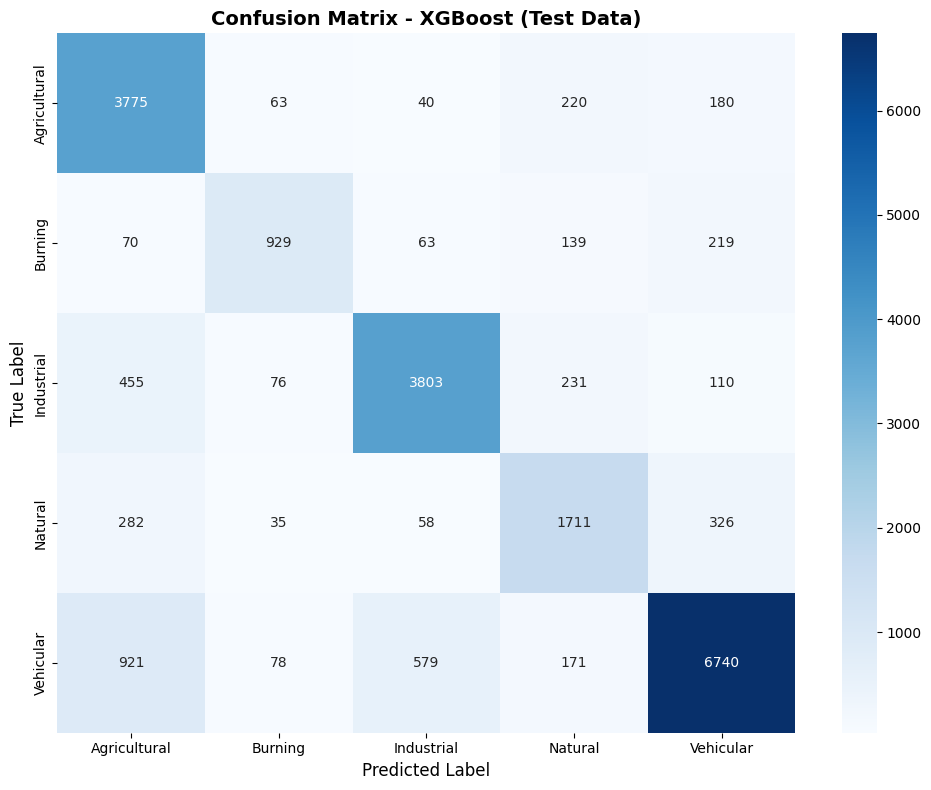


📊 Per-Class Accuracy (Test Data):
   Agricultural   : 0.8824 (3775/4278)
   Burning        : 0.6542 (929/1420)
   Industrial     : 0.8135 (3803/4675)
   Natural        : 0.7094 (1711/2412)
   Vehicular      : 0.7940 (6740/8489)


In [46]:
# Plot confusion matrix for TEST DATA
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix - {model_info["best_model_name"]} (Test Data)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

# Per-class accuracy
print("\n📊 Per-Class Accuracy (Test Data):")
for i, cls in enumerate(class_names):
    class_correct = cm[i, i]
    class_total = cm[i, :].sum()
    class_acc = class_correct / class_total if class_total > 0 else 0
    print(f"   {cls:15}: {class_acc:.4f} ({class_correct}/{class_total})")

## 7. Compare All Models

📊 Comparing All Models on TEST DATA...
               Train_Acc  Test_Acc  Overfit_Gap  Precision  Recall  F1-Score
Model                                                                       
Decision Tree     0.7474    0.7404       0.0070     0.7579  0.7404    0.7444
Random Forest     0.7907    0.7836       0.0071     0.7977  0.7836    0.7856
XGBoost           0.8043    0.7971       0.0071     0.8079  0.7971    0.7985

📊 Overfitting Analysis:
   Decision Tree: Gap=0.0070 ✅ Good
   Random Forest: Gap=0.0071 ✅ Good
   XGBoost: Gap=0.0071 ✅ Good


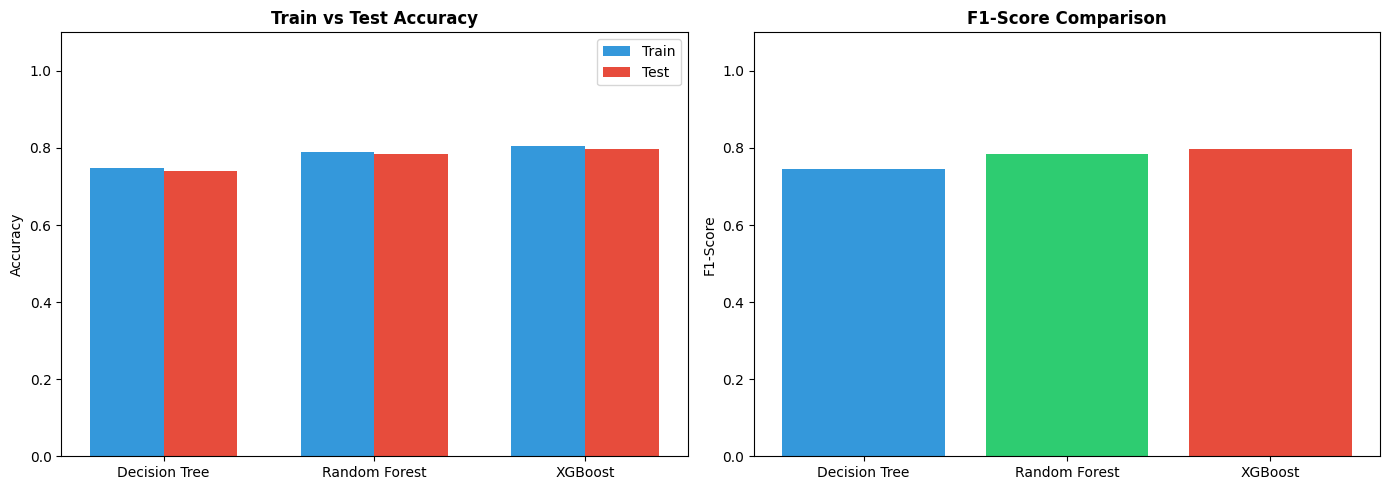

In [47]:
print("📊 Comparing All Models on TEST DATA...")
print("="*60)

models = {
    'Decision Tree': dt_model,
    'Random Forest': rf_model
}
if XGBOOST_AVAILABLE:
    models['XGBoost'] = xgb_model

results = []
for name, model in models.items():
    # Test predictions
    test_pred = model.predict(X_test_scaled)
    test_acc = accuracy_score(y_test, test_pred)
    
    # Train predictions (for overfitting check)
    train_pred = model.predict(scaler.transform(X_train))
    train_acc = accuracy_score(y_train, train_pred)
    
    results.append({
        'Model': name,
        'Train_Acc': train_acc,
        'Test_Acc': test_acc,
        'Overfit_Gap': train_acc - test_acc,
        'Precision': precision_score(y_test, test_pred, average='weighted'),
        'Recall': recall_score(y_test, test_pred, average='weighted'),
        'F1-Score': f1_score(y_test, test_pred, average='weighted')
    })

results_df = pd.DataFrame(results).set_index('Model')
print(results_df.round(4).to_string())

# Overfitting analysis
print("\n📊 Overfitting Analysis:")
for idx, row in results_df.iterrows():
    gap = row['Overfit_Gap']
    if gap > 0.15:
        status = "❌ HIGH OVERFITTING"
    elif gap > 0.05:
        status = "⚠️ Moderate"
    else:
        status = "✅ Good"
    print(f"   {idx}: Gap={gap:.4f} {status}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Train vs Test Accuracy
x = np.arange(len(results_df))
width = 0.35
axes[0].bar(x - width/2, results_df['Train_Acc'], width, label='Train', color='#3498db')
axes[0].bar(x + width/2, results_df['Test_Acc'], width, label='Test', color='#e74c3c')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Train vs Test Accuracy', fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(results_df.index)
axes[0].legend()
axes[0].set_ylim(0, 1.1)

# Plot 2: F1-Score
axes[1].bar(results_df.index, results_df['F1-Score'], color=['#3498db', '#2ecc71', '#e74c3c'][:len(results_df)])
axes[1].set_ylabel('F1-Score')
axes[1].set_title('F1-Score Comparison', fontweight='bold')
axes[1].set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

## 8. Test with Random Samples

In [48]:
print("🎯 Testing with Random Samples from TEST SET...")
print("="*60)

# Select random samples FROM TEST SET ONLY (unseen data)
np.random.seed(42)
n_samples = min(20, len(X_test))
sample_indices = np.random.choice(len(X_test), size=n_samples, replace=False)

sample_X = X_test[sample_indices]
sample_y_true = y_test[sample_indices]
sample_X_scaled = scaler.transform(sample_X)

# Predict
sample_pred = best_model.predict(sample_X_scaled)
sample_pred_labels = label_encoder.inverse_transform(sample_pred)
sample_true_labels = label_encoder.inverse_transform(sample_y_true)

# Display results
print("\n📊 Random Sample Predictions (from UNSEEN test data):")
print("-"*70)

correct = 0
for i in range(n_samples):
    actual = sample_true_labels[i]
    predicted = sample_pred_labels[i]
    status = "✅" if actual == predicted else "❌"
    if actual == predicted:
        correct += 1
    print(f"{i+1:2}. {status} Actual: {actual:15} | Predicted: {predicted}")

print("-"*70)
sample_acc = correct / n_samples * 100
print(f"\n📊 Sample Accuracy: {correct}/{n_samples} ({sample_acc:.1f}%)")

if sample_acc > 95:
    print("⚠️ Very high sample accuracy - verify model isn't overfitting")
elif sample_acc >= 70:
    print("✅ Good sample accuracy!")
else:
    print("⚠️ Lower accuracy - model may need improvement")

🎯 Testing with Random Samples from TEST SET...

📊 Random Sample Predictions (from UNSEEN test data):
----------------------------------------------------------------------
 1. ✅ Actual: Vehicular       | Predicted: Vehicular
 2. ✅ Actual: Industrial      | Predicted: Industrial
 3. ✅ Actual: Natural         | Predicted: Natural
 4. ✅ Actual: Industrial      | Predicted: Industrial
 5. ✅ Actual: Agricultural    | Predicted: Agricultural
 6. ❌ Actual: Vehicular       | Predicted: Agricultural
 7. ❌ Actual: Vehicular       | Predicted: Industrial
 8. ✅ Actual: Vehicular       | Predicted: Vehicular
 9. ✅ Actual: Vehicular       | Predicted: Vehicular
10. ❌ Actual: Agricultural    | Predicted: Natural
11. ✅ Actual: Agricultural    | Predicted: Agricultural
12. ✅ Actual: Vehicular       | Predicted: Vehicular
13. ✅ Actual: Agricultural    | Predicted: Agricultural
14. ❌ Actual: Vehicular       | Predicted: Agricultural
15. ✅ Actual: Vehicular       | Predicted: Vehicular
16. ✅ Actual: Indus

## 9. Real-Time Prediction Function

In [49]:
def predict_pollution_source(pm25, pm10, no2, co, so2, o3, 
                              temperature=25, humidity=50, wind_speed=5,
                              dist_to_road=500, dist_to_industrial=1000,
                              dist_to_agricultural=1000, dist_to_dump=2000):
    """
    Predict pollution source from sensor readings.
    
    Parameters:
    -----------
    pm25 : float - PM2.5 concentration (µg/m³)
    pm10 : float - PM10 concentration (µg/m³)
    no2 : float - NO2 concentration (ppb)
    co : float - CO concentration (ppm)
    so2 : float - SO2 concentration (ppb)
    o3 : float - O3 concentration (ppb)
    temperature : float - Temperature (°C)
    humidity : float - Relative Humidity (%)
    wind_speed : float - Wind Speed (m/s)
    dist_to_road : float - Distance to nearest road (m)
    dist_to_industrial : float - Distance to industrial area (m)
    dist_to_agricultural : float - Distance to agricultural area (m)
    dist_to_dump : float - Distance to dump site (m)
    
    Returns:
    --------
    str : Predicted pollution source
    dict : Prediction probabilities (if available)
    """
    # Create feature dict
    features = {
        'pm25': pm25, 'pm10': pm10, 'no2': no2, 'co': co, 'so2': so2, 'o3': o3,
        'temperature': temperature, 'humidity': humidity, 'wind_speed': wind_speed,
        'dist_to_road': dist_to_road, 'dist_to_industrial': dist_to_industrial,
        'dist_to_agricultural': dist_to_agricultural, 'dist_to_dump': dist_to_dump
    }
    
    # Get only required features
    X = np.array([[features.get(f, 0) for f in feature_cols]])
    
    # Scale
    X_scaled = scaler.transform(X)
    
    # Predict
    pred = best_model.predict(X_scaled)[0]
    pred_label = label_encoder.inverse_transform([pred])[0]
    
    # Get probabilities if available
    proba = None
    if hasattr(best_model, 'predict_proba'):
        proba = best_model.predict_proba(X_scaled)[0]
        proba = dict(zip(class_names, proba))
    
    return pred_label, proba

print("✅ Prediction function defined!")

✅ Prediction function defined!


## 10. Test Real-Time Predictions

In [50]:
print("🔮 Testing Real-Time Predictions...")
print("="*60)

# Test Case 1: High PM levels near road (likely Vehicular)
print("\n📍 Test Case 1: High PM near road")
pred, proba = predict_pollution_source(
    pm25=150, pm10=200, no2=80, co=2.5, so2=20, o3=40,
    temperature=30, humidity=60, wind_speed=3,
    dist_to_road=50
)
print(f"   Prediction: {pred}")
if proba:
    print(f"   Probabilities:")
    for cls, prob in sorted(proba.items(), key=lambda x: -x[1]):
        print(f"      {cls}: {prob:.4f}")

# Test Case 2: High SO2 near industry (likely Industrial)
print("\n📍 Test Case 2: High SO2 near industry")
pred, proba = predict_pollution_source(
    pm25=80, pm10=120, no2=50, co=1.5, so2=100, o3=30,
    temperature=28, humidity=55, wind_speed=4,
    dist_to_industrial=100
)
print(f"   Prediction: {pred}")
if proba:
    print(f"   Probabilities:")
    for cls, prob in sorted(proba.items(), key=lambda x: -x[1]):
        print(f"      {cls}: {prob:.4f}")

# Test Case 3: Low pollution, natural area
print("\n📍 Test Case 3: Clean area (likely Natural)")
pred, proba = predict_pollution_source(
    pm25=15, pm10=25, no2=10, co=0.3, so2=5, o3=50,
    temperature=22, humidity=45, wind_speed=8
)
print(f"   Prediction: {pred}")
if proba:
    print(f"   Probabilities:")
    for cls, prob in sorted(proba.items(), key=lambda x: -x[1]):
        print(f"      {cls}: {prob:.4f}")

# Test Case 4: Agricultural area
print("\n📍 Test Case 4: Near agricultural area")
pred, proba = predict_pollution_source(
    pm25=60, pm10=100, no2=20, co=0.5, so2=10, o3=45,
    temperature=32, humidity=70, wind_speed=5,
    dist_to_agricultural=100
)
print(f"   Prediction: {pred}")
if proba:
    print(f"   Probabilities:")
    for cls, prob in sorted(proba.items(), key=lambda x: -x[1]):
        print(f"      {cls}: {prob:.4f}")

🔮 Testing Real-Time Predictions...

📍 Test Case 1: High PM near road
   Prediction: Industrial
   Probabilities:
      Industrial: 0.4692
      Vehicular: 0.4417
      Agricultural: 0.0883
      Burning: 0.0005
      Natural: 0.0002

📍 Test Case 2: High SO2 near industry
   Prediction: Industrial
   Probabilities:
      Industrial: 0.9497
      Agricultural: 0.0441
      Vehicular: 0.0061
      Natural: 0.0001
      Burning: 0.0001

📍 Test Case 3: Clean area (likely Natural)
   Prediction: Natural
   Probabilities:
      Natural: 0.7632
      Agricultural: 0.2262
      Vehicular: 0.0074
      Industrial: 0.0028
      Burning: 0.0004

📍 Test Case 4: Near agricultural area
   Prediction: Agricultural
   Probabilities:
      Agricultural: 0.8543
      Vehicular: 0.1245
      Industrial: 0.0150
      Natural: 0.0060
      Burning: 0.0003


## 11. Batch Prediction Test

In [51]:
print("📦 Batch Prediction Test...")
print("="*60)

# Create test batch
test_batch = pd.DataFrame([
    {'pm25': 120, 'pm10': 180, 'no2': 70, 'co': 2.0, 'so2': 15, 'o3': 35, 
     'temperature': 28, 'humidity': 55, 'wind_speed': 4},
    {'pm25': 90, 'pm10': 140, 'no2': 45, 'co': 1.2, 'so2': 80, 'o3': 25,
     'temperature': 30, 'humidity': 50, 'wind_speed': 3},
    {'pm25': 20, 'pm10': 35, 'no2': 15, 'co': 0.4, 'so2': 8, 'o3': 55,
     'temperature': 24, 'humidity': 40, 'wind_speed': 10},
    {'pm25': 200, 'pm10': 300, 'no2': 30, 'co': 1.0, 'so2': 12, 'o3': 30,
     'temperature': 35, 'humidity': 30, 'wind_speed': 2},
    {'pm25': 75, 'pm10': 110, 'no2': 55, 'co': 1.8, 'so2': 25, 'o3': 40,
     'temperature': 27, 'humidity': 65, 'wind_speed': 5}
])

# Add missing columns with defaults
for col in feature_cols:
    if col not in test_batch.columns:
        test_batch[col] = 1000  # Default distance

# Prepare and predict
batch_X = test_batch[feature_cols].values
batch_X_scaled = scaler.transform(batch_X)
batch_pred = best_model.predict(batch_X_scaled)
batch_labels = label_encoder.inverse_transform(batch_pred)

# Display results
test_batch['Predicted_Source'] = batch_labels
print("\n📊 Batch Predictions:")
print(test_batch[['pm25', 'pm10', 'no2', 'so2', 'Predicted_Source']].to_string(index=False))

📦 Batch Prediction Test...

📊 Batch Predictions:
 pm25  pm10  no2  so2 Predicted_Source
  120   180   70   15        Vehicular
   90   140   45   80       Industrial
   20    35   15    8     Agricultural
  200   300   30   12        Vehicular
   75   110   55   25       Industrial


## 12. Summary

In [52]:
print("\n" + "="*70)
print("🎉 MODEL TESTING COMPLETE!")
print("="*70)

print(f"\n📊 MODEL SUMMARY:")
print(f"   Best Model: {model_info['best_model_name']}")
print(f"   Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"   F1-Score: {f1:.4f}")
print(f"   Classes: {list(class_names)}")

print(f"\n✅ MODEL VALIDATION:")
if accuracy >= 0.7:
    print(f"   ✅ Good accuracy (>= 70%)")
elif accuracy >= 0.5:
    print(f"   ⚠️ Moderate accuracy (50-70%)")
else:
    print(f"   ❌ Low accuracy (< 50%)")

print(f"\n📁 MODEL FILES:")
for f in os.listdir('models'):
    print(f"   models/{f}")

print("\n" + "="*70)
print("✅ Models validated and ready for dashboard integration!")
print("="*70)


🎉 MODEL TESTING COMPLETE!

📊 MODEL SUMMARY:
   Best Model: XGBoost
   Accuracy: 0.7971 (79.71%)
   F1-Score: 0.7985
   Classes: ['Agricultural', 'Burning', 'Industrial', 'Natural', 'Vehicular']

✅ MODEL VALIDATION:
   ✅ Good accuracy (>= 70%)

📁 MODEL FILES:
   models/best_model.joblib
   models/best_model.pkl
   models/decision_tree_model.joblib
   models/feature_columns.txt
   models/label_encoder.joblib
   models/model_info.json
   models/model_info.pkl
   models/random_forest_model.joblib
   models/scaler.joblib
   models/xgboost_model.joblib

✅ Models validated and ready for dashboard integration!
